In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings

In [7]:

file_path = r"C:\Users\lidiv\Downloads\WMT.csv"
df = pd.read_csv(file_path)
df

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828
...,...,...
5474,2020-12-25,NaN
5475,2020-12-28,142.946777
5476,2020-12-29,142.041183
5477,2020-12-30,141.923065


In [8]:
# Convert 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [9]:
# Create datetime index with business day frequency
df = df.asfreq('B')
df

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [10]:
# Check and handle null values
if df.isnull().values.any():
    df = df.fillna(method='ffill') 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2000-01-03 to 2020-12-31
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5479 non-null   float64
dtypes: float64(1)
memory usage: 85.6 KB


In [12]:
df.columns

Index(['Adj Close'], dtype='object')

In [13]:
# Check for stationarity
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
test_stationarity(df['Adj Close'])

ADF Statistic: 2.4576397338087372
p-value: 0.9990349038956786
Critical Values: {'1%': -3.4315513193059908, '5%': -2.8620708627986335, '10%': -2.5670525772661414}


In [14]:
# Determine the number of differencing needed
differencing_needed = ndiffs(df['Adj Close'])
print('Number of Differencing needed:', differencing_needed)


Number of Differencing needed: 2


C:\Users\lidiv\anaconda3\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


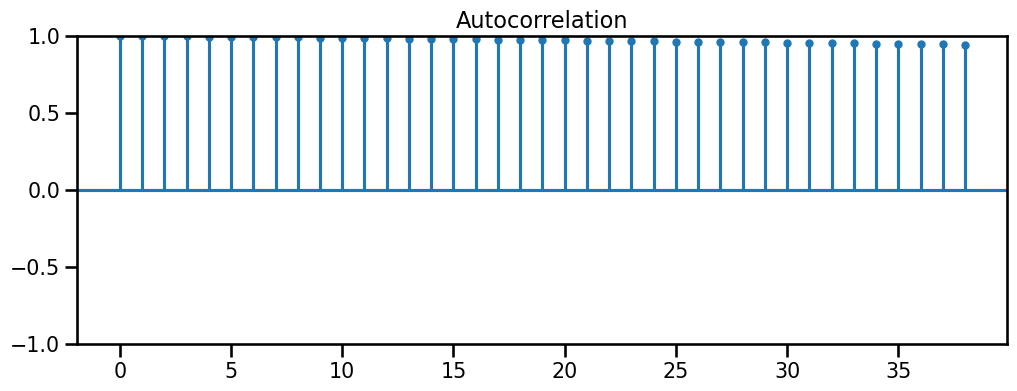

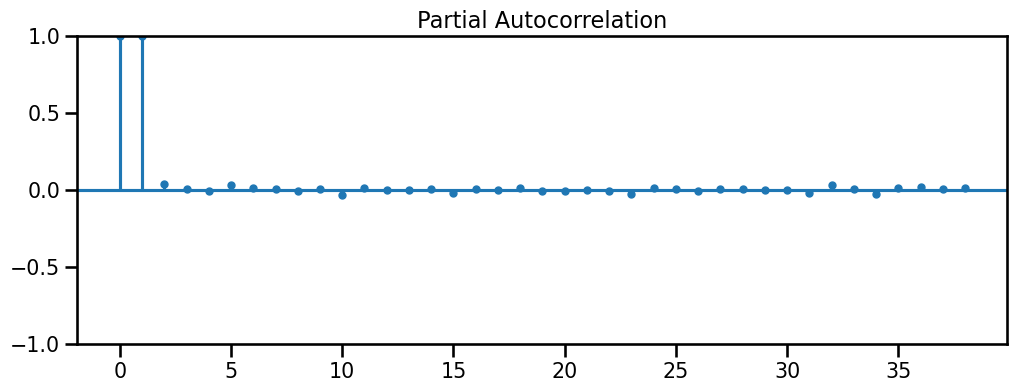

In [15]:
# ACF and PACF plots
plot_acf(df['Adj Close'])
plot_pacf(df['Adj Close'])
plt.show()

In [16]:
13 * 6

78

In [17]:
# Split the time series into training and test data
test_size = 13 * 6
train, test = df[:-test_size], df[-test_size:]

In [18]:
p, d, q = 1, 2, 1

# Fit an ARIMA model 
model = ARIMA(train, order=(p, d, q))
fit_model = model.fit()

In [19]:

# Fit an ARIMA model
order = (1, 2, 1) 
model = ARIMA(train, order=order)
fit_model = model.fit()


In [20]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5401
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -6625.374
Date:                Wed, 13 Dec 2023   AIC                          13256.748
Time:                        21:12:01   BIC                          13276.530
Sample:                    01-03-2000   HQIC                         13263.655
                         - 09-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0980      0.004    -24.112      0.000      -0.106      -0.090
ma.L1         -0.9992      0.001  -1686.249      0.000      -1.000      -0.998
sigma2         0.6806      0.003    206.474      0.000       0.674       0.687
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            237592.72
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

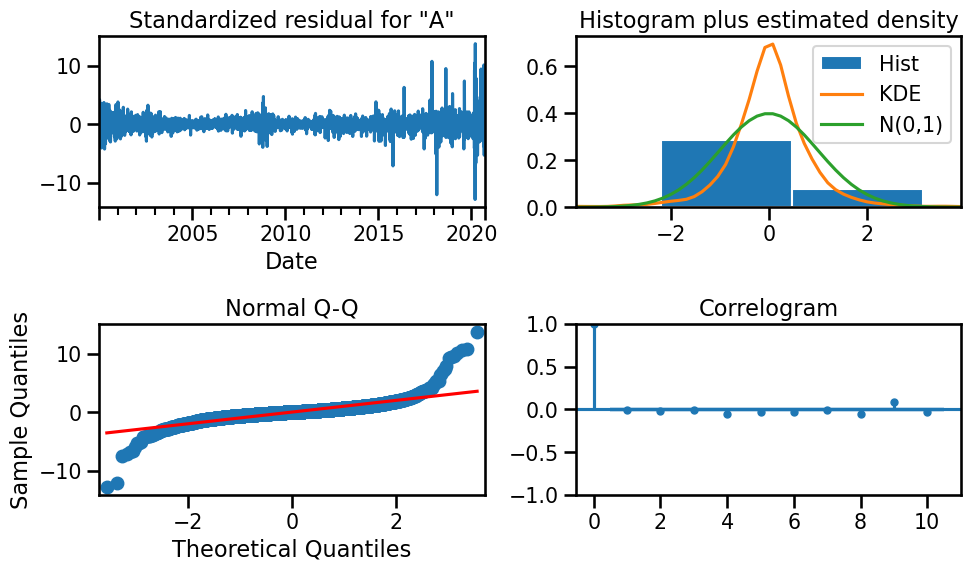

In [21]:
# Obtain diagnostic plots
fig = fit_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 5.566
- MSE = 43.962
- RMSE = 6.630
- R^2 = -1.131
- MAPE = 3.85%


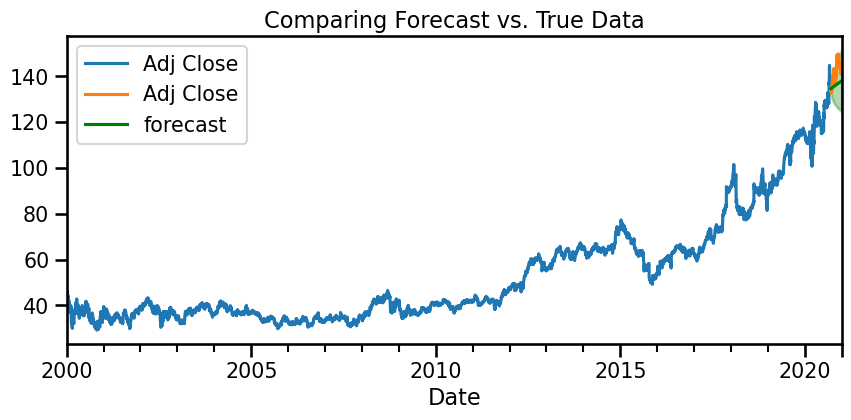

In [22]:

# Obtain summary of forecast as dataframe
forecast_df = fit_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])


In [24]:
p_final, d_final, q_final = 2, 2, 1
# Choose a final model and explain

final_order = (p_final, d_final, q_final)
final_model = ARIMA(df, order=final_order)
final_fit_model = final_model.fit()

# Evaluate the final model
final_forecast = final_fit_model.predict(start=len(df), end=len(df) + len(test) - 1, typ='levels')
final_mape = mean_absolute_error(test, final_forecast) / np.mean(test) * 100
print('Final Model MAPE:', final_mape)

Final Model MAPE: Adj Close    2.641503
dtype: float64


C:\Users\lidiv\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\lidiv\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [27]:
# Obtain metrics for evaluation
mape = mean_absolute_error(test, final_forecast) / np.mean(test) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Percentage Error (MAPE): Adj Close    2.641503
dtype: float64


C:\Users\lidiv\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [28]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [2]          
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [29]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 17539.760433007228
(0, 2, 1) 13306.78455469429
(0, 2, 2) 13255.146944056754
(1, 2, 0) 15675.44334952297
(1, 2, 1) 13256.748496066211
(1, 2, 2) 13310.78325838687
(2, 2, 0) 14940.047902712615
(2, 2, 1) 13256.881535488756
(2, 2, 2) 13250.460327224195
Best AIC: 13250.460327224195
Best pdq: (2, 2, 2)
